<a href="https://colab.research.google.com/github/rajanaids-hub/Reinforcement_Learning_Lab/blob/main/Monte_Carlo_Blackjack_Exp5_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

♠️ ♥️ Creating Blackjack Environment... ♦️ ♣️
🧠 Training Monte Carlo Agent by playing 500,000 hands of Blackjack...
   (This takes a few seconds because it has to simulate every single game!)
   Played 100,000 hands... (Epsilon: 0.368)
   Played 200,000 hands... (Epsilon: 0.135)
   Played 300,000 hands... (Epsilon: 0.100)
   Played 400,000 hands... (Epsilon: 0.100)
   Played 500,000 hands... (Epsilon: 0.100)

✅ Training Complete!

🎲 Evaluating the learned strategy over 100,000 games...
----------------------------------------
🏆 Win Rate:  43.48%
💀 Loss Rate: 48.48%
🤝 Draw Rate: 8.04%
----------------------------------------
💡 Note: A perfect basic strategy in Blackjack yields a win rate of ~42.5%.
   (The house always has an edge!)

📊 Generating Strategy Charts...


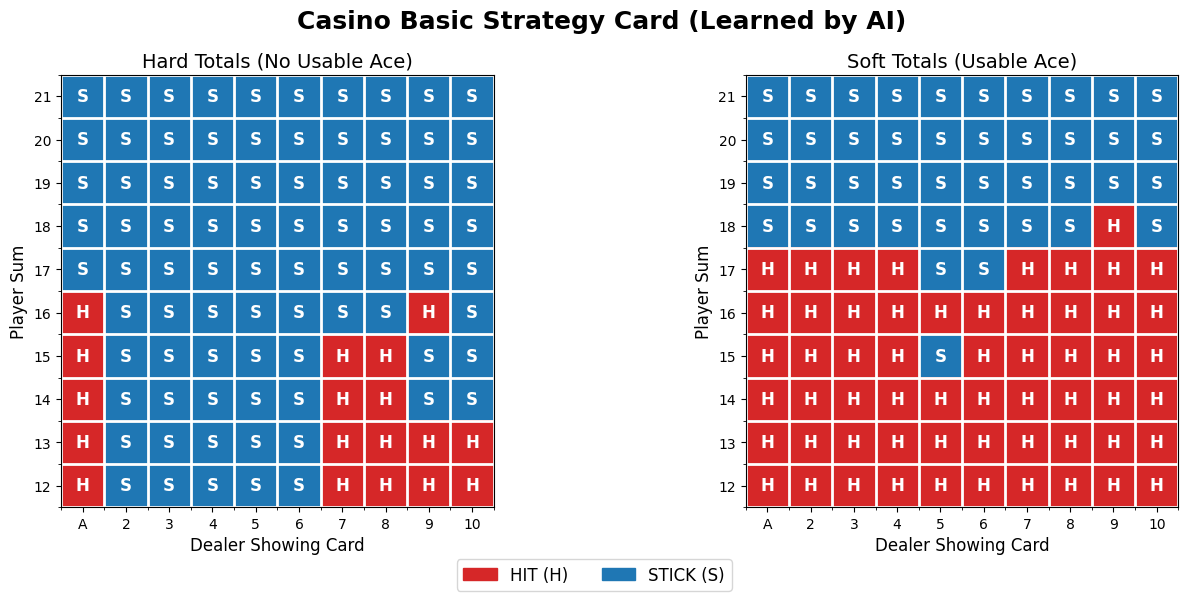

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gymnasium as gym
from matplotlib.colors import ListedColormap

# =====================================================================
# 🎓 STUDENT EXPERIMENT SETTINGS: MONTE CARLO 🎓
# =====================================================================
# Monte Carlo requires a LOT of episodes because it only updates at the
# very end of a game. Half a million games is standard for Blackjack!
EPISODES = 500_000
GAMMA = 1.0             # Discount factor (No discount for Blackjack)
EPSILON_START = 1.0     # Start by exploring 100% of the time
EPSILON_DECAY = 0.99999 # Slowly decay exploration to focus on exploitation
EPSILON_MIN = 0.1       # Always keep a 10% chance to explore
# =====================================================================

class MonteCarloAgent:
    def __init__(self, action_space):
        self.action_space = action_space

        # Q-Table mapping State -> Array of Action Values [Q(Stick), Q(Hit)]
        # We use defaultdict so unseen states automatically start at [0.0, 0.0]
        self.q_table = defaultdict(lambda: np.zeros(self.action_space.n))

        # Keep track of how many times we've taken an action in a state
        # We need this to calculate the true average of returns
        self.state_action_counts = defaultdict(float)

        self.epsilon = EPSILON_START

    def choose_action(self, state):
        """Epsilon-greedy policy for choosing an action."""
        if np.random.random() < self.epsilon:
            return self.action_space.sample() # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def update_q_table(self, episode_history):
        """
        The core of Monte Carlo Control!
        We wait until the game is OVER, then we look back at our history and update.
        episode_history is a list of tuples: (state, action, reward)
        """
        G = 0 # "G" stands for Total Return (Cumulative Reward)

        # We process the episode backwards: from the end of the game to the start
        # This allows us to easily calculate the total future reward (Return) from any point
        for state, action, reward in reversed(episode_history):
            # Calculate total return from this step onwards
            G = reward + GAMMA * G

            # For First-Visit MC: We technically should check if this is the FIRST time
            # we visited this state in the episode. But in Blackjack, you rarely
            # visit the exact same state twice in one hand, so Every-Visit MC works identically.

            # Incremental Average Update Rule:
            # NewEstimate = OldEstimate + StepSize * (Target - OldEstimate)
            self.state_action_counts[(state, action)] += 1
            alpha = 1.0 / self.state_action_counts[(state, action)] # Step size

            old_q = self.q_table[state][action]
            self.q_table[state][action] = old_q + alpha * (G - old_q)

        # Decay epsilon slightly after every episode
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

# =====================================================================
# 📊 EVALUATION: HOW GOOD IS THE AGENT?
# =====================================================================
def evaluate_agent(env, q_table, episodes=100_000):
    """Plays thousands of games using the purely learned strategy to calculate win rate."""
    print(f"\n🎲 Evaluating the learned strategy over {episodes:,} games...")
    wins, losses, draws = 0, 0, 0

    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        while not done:
            # PURE EXPLOITATION: Always take the best known action (epsilon = 0)
            action = np.argmax(q_table[state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        if reward > 0: wins += 1
        elif reward < 0: losses += 1
        else: draws += 1

    win_rate = (wins / episodes) * 100
    loss_rate = (losses / episodes) * 100
    draw_rate = (draws / episodes) * 100

    print("-" * 40)
    print(f"🏆 Win Rate:  {win_rate:.2f}%")
    print(f"💀 Loss Rate: {loss_rate:.2f}%")
    print(f"🤝 Draw Rate: {draw_rate:.2f}%")
    print("-" * 40)
    print("💡 Note: A perfect basic strategy in Blackjack yields a win rate of ~42.5%.")
    print("   (The house always has an edge!)")

# =====================================================================
# 📉 VISUALIZATION: PLOTTING THE STRATEGY
# =====================================================================
def plot_blackjack_policy(q_table):
    """
    Translates the learned Q-Table into a standard casino Blackjack basic strategy chart.
    """
    player_sums = range(12, 22) # 12 to 21
    dealer_cards = range(1, 11) # 1 (Ace) to 10

    policy_no_ace = np.zeros((len(player_sums), len(dealer_cards)))
    policy_usable_ace = np.zeros((len(player_sums), len(dealer_cards)))

    for i, p_sum in enumerate(player_sums):
        for j, d_card in enumerate(dealer_cards):
            policy_no_ace[i, j] = np.argmax(q_table[(p_sum, d_card, False)])
            policy_usable_ace[i, j] = np.argmax(q_table[(p_sum, d_card, True)])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Casino Basic Strategy Card (Learned by AI)", fontsize=18, weight='bold')

    # Custom colors: Blue for Stick (0), Red for Hit (1)
    cmap = ListedColormap(['#1f77b4', '#d62728'])
    extent = [0.5, 10.5, 11.5, 21.5] # Align pixels perfectly with standard tick marks

    # Plot No Usable Ace
    ax1.imshow(policy_no_ace, cmap=cmap, origin="lower", extent=extent)
    ax1.set_title("Hard Totals (No Usable Ace)", fontsize=14)
    ax1.set_xlabel("Dealer Showing Card", fontsize=12)
    ax1.set_ylabel("Player Sum", fontsize=12)

    # Plot Usable Ace
    ax2.imshow(policy_usable_ace, cmap=cmap, origin="lower", extent=extent)
    ax2.set_title("Soft Totals (Usable Ace)", fontsize=14)
    ax2.set_xlabel("Dealer Showing Card", fontsize=12)
    ax2.set_ylabel("Player Sum", fontsize=12)

    # Format ticks and overlay text (H / S) on the charts
    for ax, policy in zip([ax1, ax2], [policy_no_ace, policy_usable_ace]):
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))
        ax.set_xticklabels(['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

        # Draw the grid
        ax.set_xticks(np.arange(0.5, 11.5, 1), minor=True)
        ax.set_yticks(np.arange(11.5, 22.5, 1), minor=True)
        ax.grid(which="minor", color="white", linestyle='-', linewidth=2)

        # Overlay the 'H' and 'S' text
        for i, p_sum in enumerate(player_sums):
            for j, d_card in enumerate(dealer_cards):
                action_text = 'H' if policy[i, j] == 1 else 'S'
                ax.text(d_card, p_sum, action_text, ha='center', va='center', color='white', weight='bold', fontsize=12)

    # Add legend
    import matplotlib.patches as mpatches
    hit_patch = mpatches.Patch(color='#d62728', label='HIT (H)')
    stick_patch = mpatches.Patch(color='#1f77b4', label='STICK (S)')
    fig.legend(handles=[hit_patch, stick_patch], loc="lower center", ncol=2, fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# =====================================================================
# 🚀 MAIN EXECUTION
# =====================================================================
if __name__ == "__main__":
    print("♠️ ♥️ Creating Blackjack Environment... ♦️ ♣️")
    env = gym.make("Blackjack-v1", sab=True) # sab=True follows standard rules

    agent = MonteCarloAgent(env.action_space)

    print(f"🧠 Training Monte Carlo Agent by playing {EPISODES:,} hands of Blackjack...")
    print("   (This takes a few seconds because it has to simulate every single game!)")

    for episode in range(EPISODES):
        state, info = env.reset()
        episode_history = []
        done = False

        # 1. GENERATE AN EPISODE
        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # Record what happened so we can review it later
            episode_history.append((state, action, reward))

            state = next_state
            done = terminated or truncated

        # 2. UPDATE KNOWLEDGE AT THE END OF THE EPISODE
        agent.update_q_table(episode_history)

        if (episode + 1) % 100_000 == 0:
            print(f"   Played {episode + 1:,} hands... (Epsilon: {agent.epsilon:.3f})")

    print("\n✅ Training Complete!")

    # Evaluate how good the agent is
    evaluate_agent(env, agent.q_table)

    env.close()

    print("\n📊 Generating Strategy Charts...")
    # Translate the Q-Table into visual Heatmaps
    plot_blackjack_policy(agent.q_table)